# Junk Food Classification with KNN

This notebook implements a **K-Nearest Neighbors (KNN)** classifier for image classification using a **COCO-style dataset**.  
The goal is to compare the performance of KNN against YOLO and CLIP pipelines using the same dataset and consistent evaluation metrics.

Running the pipeline is relatively quick, since it uses a pre-trained model (RestNet-50)

## Before you start

Make sure you have access to GPU. In case of any problems, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, click `Save` and try again.

In [1]:
!nvidia-smi

Sun Dec 28 22:15:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets


/content/datasets


## Install packages using pip

In [4]:
!pip install roboflow==1.2.11 torch==2.9.0 torchvision==0.24.0 scikit-learn==1.6.1 tqdm==4.67.1 ultralytics==8.3.241

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 128.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## Download dataset from Roboflow

Don't forget to change the `API_KEY` with your dataset key.

We replicate your original dataset setup. Even though the dataset is labeled for object detection, we’ll use the full image classification approach with KNN. Labels will be derived from the most frequent class per image.

In [5]:
from roboflow import Roboflow
from google.colab import userdata

rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace(userdata.get('ROBOFLOW_WORKSPACE_ID')).project(userdata.get('ROBOFLOW_PROJECT_ID'))
version = project.version(userdata.get('ROBOFLOW_DATASET_VERSION'))
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Junk-Food-Detection-10 in coco:: 100%|██████████| 5280/5280 [00:00<00:00, 5707.86it/s]


In [6]:
%cd {HOME}

/content


## Convert COCO detection dataset to binary classification

We will use a classification model. So, for labeling, we use two classes: junk-food-ad and non-junk-food-ad. Given the fact that the dataset is multiclass, the rule is: if there is at least one bounding box belonging to a particular image, it's junk-food-ad. Otherwise, it's non-junk-food-ad

In [7]:
import json
import os
import shutil
from collections import defaultdict

base_dir = dataset.location
splits = ['train', 'valid', 'test']

CLASSIFICATION_DATASET_PATH = os.path.join(os.path.dirname(base_dir), 'classification_dataset')

print(f"Converting dataset from: {base_dir}")
print(f"Output will be saved to: {CLASSIFICATION_DATASET_PATH}\n")

for split in splits:
    split_dir = os.path.join(base_dir, split)
    coco_json_path = os.path.join(split_dir, '_annotations.coco.json')

    if not os.path.exists(coco_json_path):
        print(f"Warning: {coco_json_path} not found, skipping {split}")
        continue

    print(f"Processing {split} split...")

    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Create a mapping of image_id to list of annotations
    image_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        image_annotations[ann['image_id']].append(ann)

    # Create output directories for this split
    junk_food_dir = os.path.join(CLASSIFICATION_DATASET_PATH, split, 'junk-food-ad')
    non_junk_food_dir = os.path.join(CLASSIFICATION_DATASET_PATH, split, 'non-junk-food-ad')
    os.makedirs(junk_food_dir, exist_ok=True)
    os.makedirs(non_junk_food_dir, exist_ok=True)

    # Process each image
    junk_food_count = 0
    non_junk_food_count = 0

    for image_info in coco_data['images']:
        image_id = image_info['id']
        file_name = image_info['file_name']
        source_path = os.path.join(split_dir, file_name)

        if not os.path.exists(source_path):
            print(f"  Warning: Image {file_name} not found, skipping")
            continue

        # Check if image has any bounding box
        has_annotations = image_id in image_annotations and len(image_annotations[image_id]) > 0

        if has_annotations:
            dest_path = os.path.join(junk_food_dir, file_name)
            shutil.copy2(source_path, dest_path)
            junk_food_count += 1
        else:
            dest_path = os.path.join(non_junk_food_dir, file_name)
            shutil.copy2(source_path, dest_path)
            non_junk_food_count += 1

    print(f"  ✓ {split} - junk-food-ad: {junk_food_count} images")
    print(f"  ✓ {split} - non-junk-food-ad: {non_junk_food_count} images")
    print(f"  Total: {junk_food_count + non_junk_food_count} images\n")

Converting dataset from: /content/datasets/Junk-Food-Detection-10
Output will be saved to: /content/datasets/classification_dataset

Processing train split...
  ✓ train - junk-food-ad: 2925 images
  ✓ train - non-junk-food-ad: 1689 images
  Total: 4614 images

Processing valid split...
  ✓ valid - junk-food-ad: 277 images
  ✓ valid - non-junk-food-ad: 163 images
  Total: 440 images

Processing test split...
  ✓ test - junk-food-ad: 131 images
  ✓ test - non-junk-food-ad: 87 images
  Total: 218 images



## Train Classification YOLO11 model with dataset

In [8]:
from ultralytics import YOLO

model = YOLO('yolo11m-cls.pt')

model.train(
    data=CLASSIFICATION_DATASET_PATH,
    epochs=200,
    imgsz=640,
    device=0,
    patience=30
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/classification_dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ed293bcfd40>
curves: []
curves_results: []
fitness: 0.9443181753158569
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8886363506317139, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9443181753158569}
save_dir: PosixPath('/content/runs/classify/train')
speed: {'preprocess': 0.5389537727265551, 'inference': 1.370730390907614, 'loss': 0.010369188636228831, 'postprocess': 0.0010675272723016283}
task: 'classify'
top1: 0.8886363506317139
top5: 1.0

## Run predictions on test set

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m-cls summary (fused): 57 layers, 10,344,194 parameters, 0 gradients, 39.3 GFLOPs
train: /content/datasets/classification_dataset/train... found 4614 images in 2 classes ✅ 
val: /content/datasets/classification_dataset/valid... found 440 images in 2 classes ✅ 
test: /content/datasets/classification_dataset/test... found 218 images in 2 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 867.0±223.6 MB/s, size: 38.1 KB)
test: Scanning /content/datasets/classification_dataset/test... 218 images, 0 corrupt: 100% ━━━━━━━━━━━━ 218/218 3.3Kit/s 0.1s
test: New cache created: /content/datasets/classification_dataset/test.cache
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 14/14 6.9it/s 2.0s
                   all      0.844          1
Speed: 0.9ms preprocess, 4.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val


TEST 

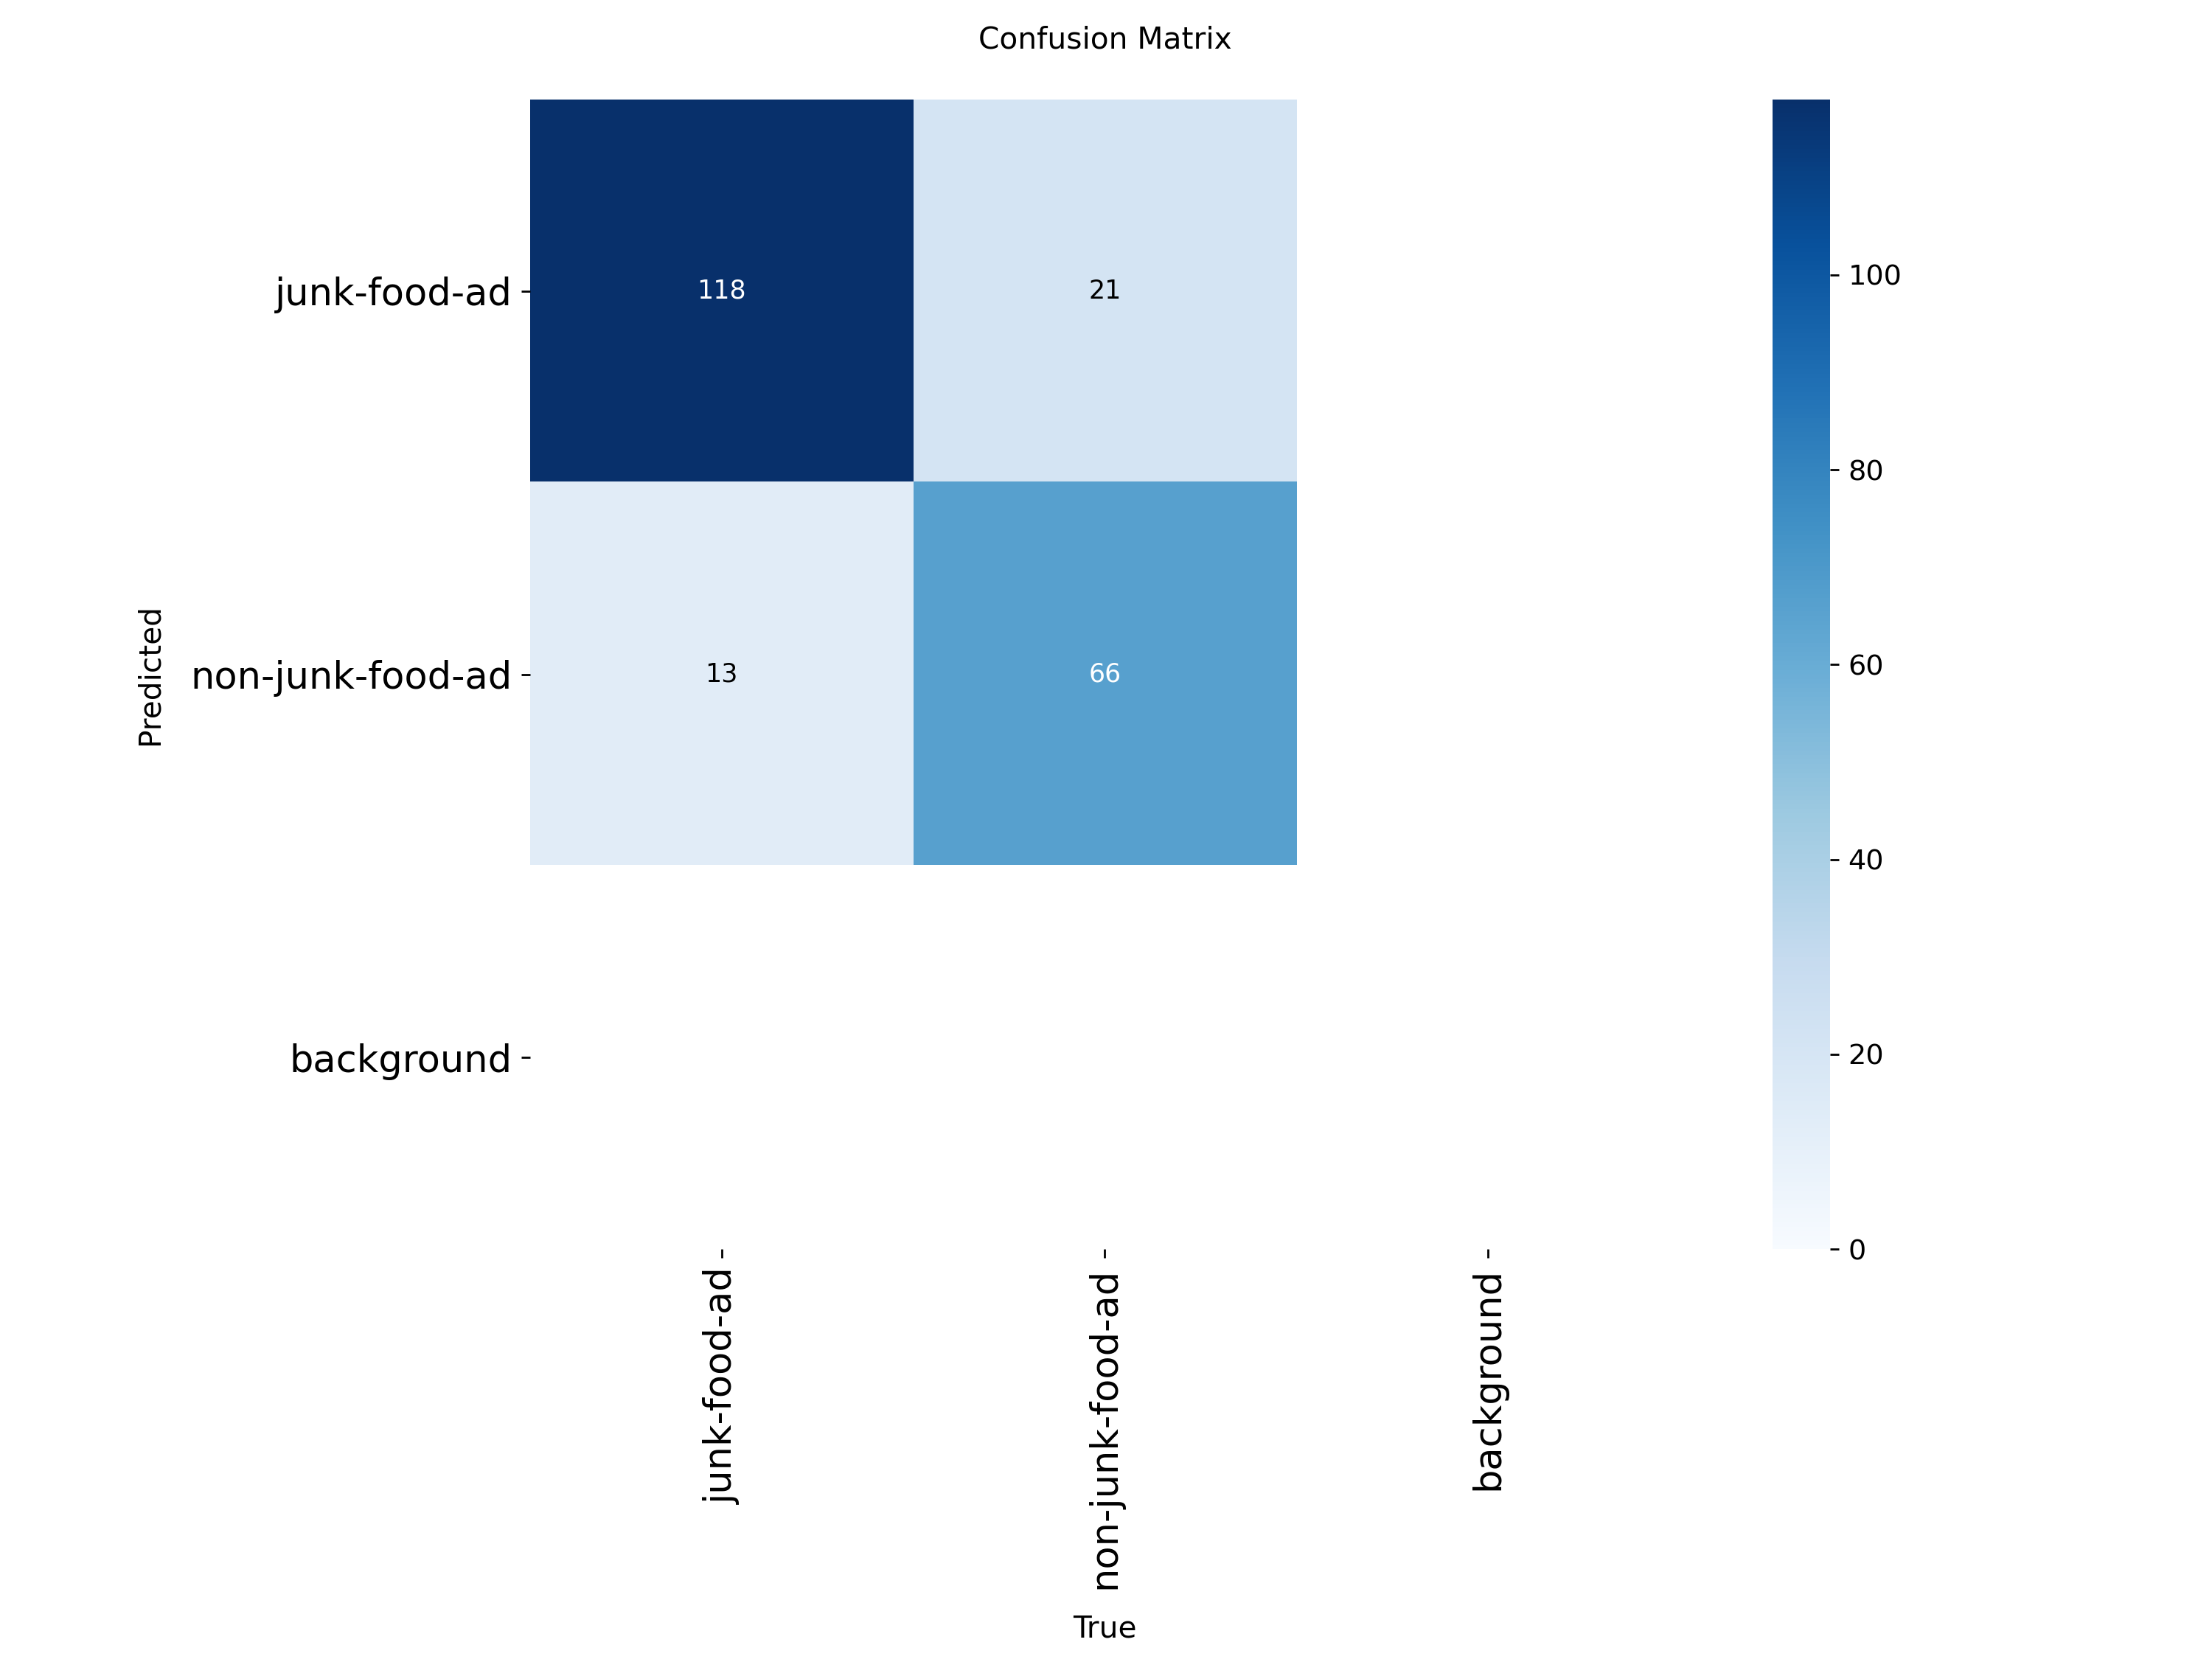

In [9]:
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import os
from IPython.display import Image, display

model = YOLO('runs/classify/train/weights/best.pt')

results = model.val(
    data=CLASSIFICATION_DATASET_PATH,
    split='test',
    imgsz=640,
    device=0
)

print("\n\n" + "="*50)
print("TEST SET METRICS")
print("="*50)

if hasattr(results, 'confusion_matrix'):
    cm = results.confusion_matrix.matrix.astype(int)

    # Reconstruct y_true and y_pred from confusion matrix
    y_true = []
    y_pred = []
    for true_class in range(cm.shape[0]):
        for pred_class in range(cm.shape[1]):
            count = int(cm[true_class, pred_class])
            y_true.extend([true_class] * count)
            y_pred.extend([pred_class] * count)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    class_names = list(model.names.values()) if hasattr(model, 'names') else ['Class 0', 'Class 1']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=0)
    recall = recall_score(y_true, y_pred, pos_label=0)
    f1 = f1_score(y_true, y_pred, pos_label=0)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Accuracy from YOLO results: {results.top1}")
    print(f"Precision: {precision:.3f} ({class_names[0]})")
    print(f"Recall: {recall:.3f} ({class_names[0]})")
    print(f"F1-Score: {f1:.3f} ({class_names[0]})")

cm_path = os.path.join(results.save_dir, 'confusion_matrix.png')
if os.path.exists(cm_path):
    print(f"Confusion Matrix:")
    display(Image(filename=cm_path))